In [1]:
from profiler.core import *

In [17]:
pf = Profiler(workers=2, verbose=False, tol=0, eps=0.01)

In [18]:
#pf.session.load_data(name='flights', src='file', fpath='/Users/zhihan/Documents/bart/data/clean_data/flights.csv', embedtxt=False)
pf.session.load_data(name='cancer', src='file', fpath='data/cancer.csv', embedtxt=False)


INFO:profiler.utility:[0.783113956451416] Load Data start

INFO:profiler.dataset:inferred types of attributes: {
    "Smoker": "numeric",
    "Pollution": "numeric",
    "Cancer": "numeric",
    "Xray": "numeric",
    "Dyspnoea": "numeric"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'Smoker': ['equal'], 'Pollution': ['equal'], 'Cancer': ['equal'], 'Xray': ['equal'], 'Dyspnoea': ['equal']}
INFO:profiler.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.8084452152252197] Load Data execution time: 0.02533125877380371



In [19]:
pf.session.load_training_data()

INFO:profiler.utility:[1.2343883514404297] Create Training Data start

INFO:profiler.transformer:needs multiplier = 2093 to bound the error in inv cov estimation <= 0.00100000
INFO:profiler.transformer:use multiplier = 2093, and the bound is 0.00000017
INFO:profiler.transformer:Draw Pairs
100%|██████████| 5/5 [00:09<00:00,  1.86s/it]
INFO:profiler.transformer:Number of training samples: 20950000
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[44.74230718612671] Create Training Data execution time: 43.50791883468628



In [20]:
cov = pf.session.struct_engine.estimate_covariance()

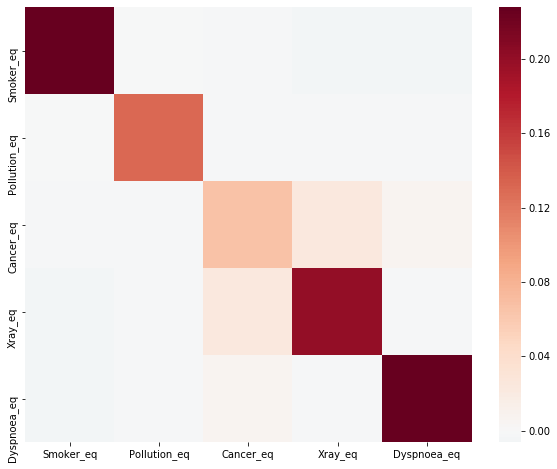

In [21]:
from profiler.utility import visualize_heatmap
visualize_heatmap(cov)

INFO:profiler.learner:use threshold 0.0014


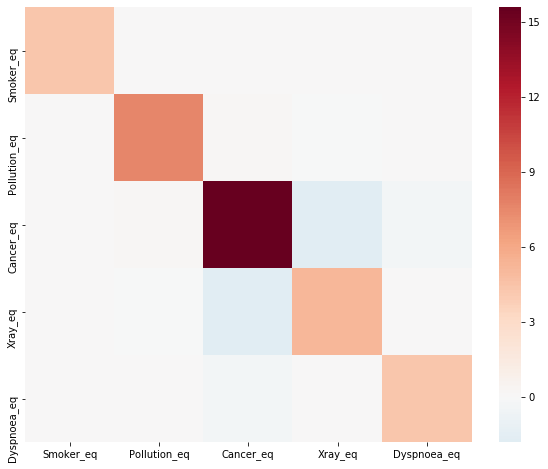

In [22]:
pf.session.struct_engine.param['sparsity'] = 0.001
inv_cov, est_cov = pf.session.struct_engine.estimate_inverse_covariance(cov.values)

Smoker_eq,Pollution_eq,Cancer_eq,Xray_eq,Dyspnoea_eq -> Smoker_eq
Smoker_eq,Pollution_eq,Cancer_eq,Xray_eq,Dyspnoea_eq -> Pollution_eq
Smoker_eq,Pollution_eq,Cancer_eq,Xray_eq,Dyspnoea_eq -> Cancer_eq
Smoker_eq,Pollution_eq,Cancer_eq,Xray_eq,Dyspnoea_eq -> Xray_eq
Smoker_eq,Pollution_eq,Cancer_eq,Xray_eq,Dyspnoea_eq -> Dyspnoea_eq


/Users/scarlet/anaconda3/envs/fd3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


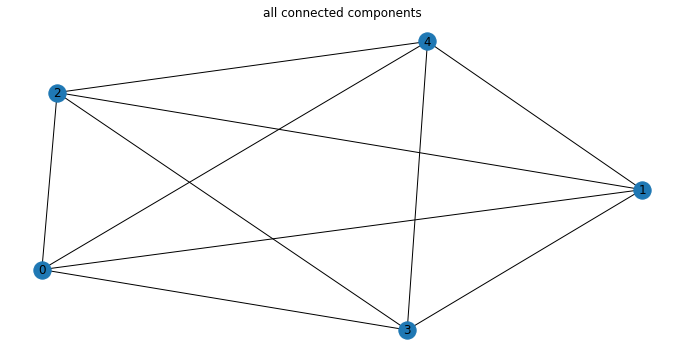

In [23]:
G = pf.session.struct_engine.recover_moral_graphs(inv_cov)
Gs = G.get_undirected_connected_components()

In [24]:
components = [list(g.idx_to_name.keys()) for g in Gs]

In [25]:
components[0]

[0, 1, 2, 3, 4]

In [26]:
from profiler.learner import StructureLearner
from sksparse.cholmod import cholesky, analyze
from itertools import permutations 
from scipy import sparse
from tqdm import tqdm
import pandas as pd

for c in components:
    U_hat = None
    # cholesky decomposition of invcov
    A = sparse.csr_matrix(inv_cov.values)
    factor = analyze(A)
    perm = factor.P()
    mat = inv_cov.iloc[perm, perm]
    A = sparse.csr_matrix(mat.values)
    factor = cholesky(A)
    U = factor.L_D()[0].toarray()
    U_hat = StructureLearner.get_df(U, inv_cov.columns.values[perm])    
    break

/Users/scarlet/anaconda3/envs/fd3/lib/python3.7/site-packages/ipykernel_launcher.py:12: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  if sys.path[0] == '':
/Users/scarlet/anaconda3/envs/fd3/lib/python3.7/site-packages/ipykernel_launcher.py:16: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  app.launch_new_instance()
/Users/scarlet/anaconda3/envs/fd3/lib/python3.7/site-packages/ipykernel_launcher.py:16: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  app.launch_new_instance()


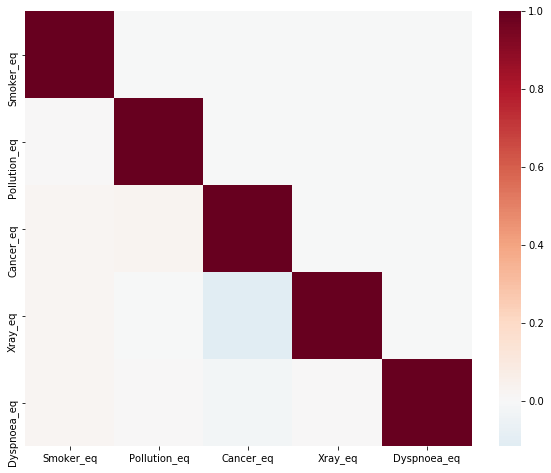

In [27]:
visualize_heatmap(U_hat)

In [28]:
for i, attr in enumerate(U_hat):
    columns = U_hat.columns.values[0:i]
    parents = columns[U_hat.iloc[i, 0:i] != 0]
    if len(parents) > 0:
        print("{} -> {}".format(",".join(parents), attr))

Smoker_eq -> Pollution_eq
Smoker_eq,Pollution_eq -> Cancer_eq
Smoker_eq,Pollution_eq,Cancer_eq -> Xray_eq
Smoker_eq,Pollution_eq,Cancer_eq,Xray_eq -> Dyspnoea_eq
